# Dark photon kinematics

I want to plot pT, eta, Lxy, and dPhi to show the range of relevant values and provide an understanding of how these quantities depend on bound state mass, dark photon mass, and dark photon proper decay length. I expect the plots produced here will end up in the AN.

In [1]:
# python
import sys
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import utilities, sidm_processor, scaleout
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

Dark photon pT, eta, and dPhi depend alost entirely on the bound state mass, so hold dark photon mass and ctau constant and plot pT, eta, and dPhi vs bound state mass.

In [2]:
client = scaleout.make_dask_client("tls://localhost:8786")
client

/home/cms-jovyan/SIDM/sidm/tools/scaleout.py:12: UserWarning: Registering a `SchedulerPlugin` as a worker plugin is not allowed, registering as a scheduler plugin instead. To register as a worker plugin, inherit from `WorkerPlugin`.
  client.register_worker_plugin(PipInstall(packages=dependencies, pip_options=["--upgrade"]))


<Client: 'tls://192.168.235.122:8786' processes=4 threads=4, memory=7.63 GiB>

In [3]:
samples = [
    "2Mu2E_100GeV_1p2GeV_9p6mm",
    "2Mu2E_150GeV_1p2GeV_6p4mm",
    "2Mu2E_200GeV_1p2GeV_4p8mm",
    "2Mu2E_500GeV_1p2GeV_1p9mm",
    "2Mu2E_800GeV_1p2GeV_1p2mm",
    "2Mu2E_1000GeV_1p2GeV_0p96mm",
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client),
    schema=NanoAODSchema,
    #maxchunks=1,
    skipbadfiles=True
)

channels = [
    "baseNoLj",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["genA_base"],
    #verbose=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

/opt/conda/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


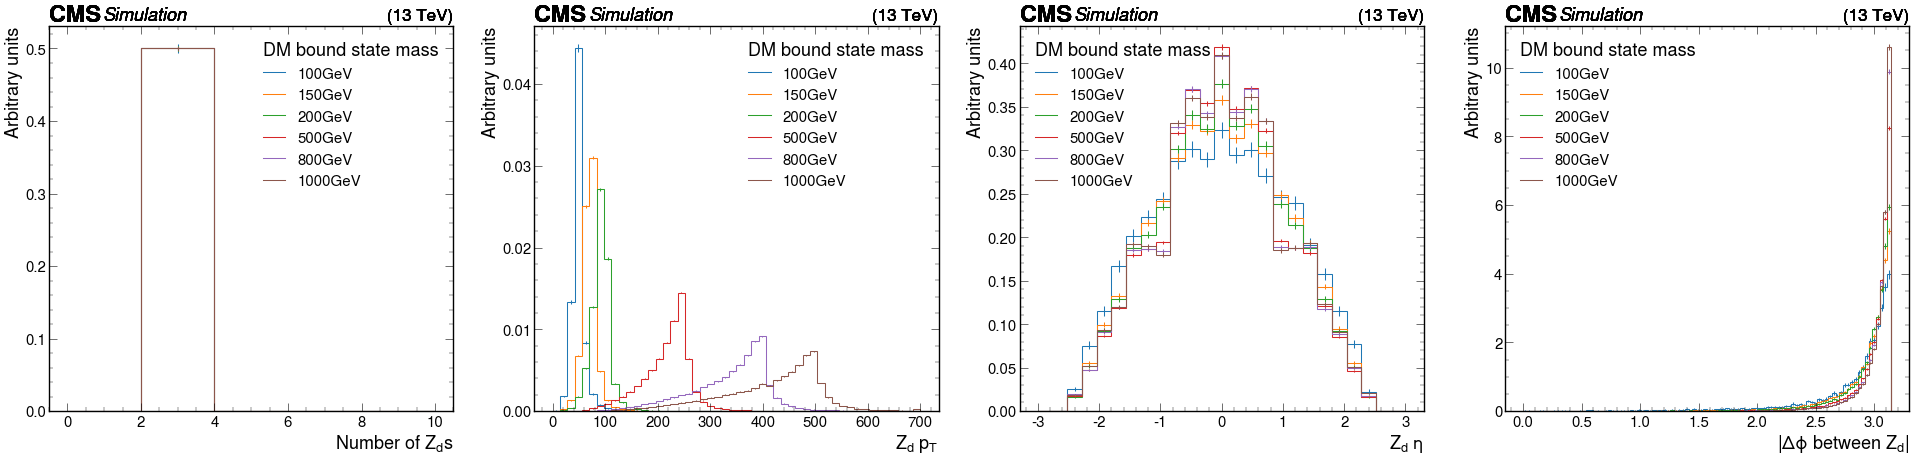

In [4]:
masses = [s.split("_")[1] for s in samples]
n = 4
plt.subplots(1, n, figsize=(n*12, 10))
plt.subplot(1, n, 1)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genAs_n"][channels[0], ::2j], density=True)
    plt.legend(masses, title="DM bound state mass", alignment="left")
    #plt.ylim(0, 0.05)
    plt.ylabel("Arbitrary units")
plt.subplot(1, n, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genAs_pt_highRange"][channels[0], ::2j], density=True)
    plt.legend(masses, title="DM bound state mass", alignment="left")
    #plt.ylim(0, 0.05)
    plt.ylabel("Arbitrary units")
plt.subplot(1, n, 3)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genAs_eta_phi"][channels[0], ::2j, :].project("genAs_eta"), density=True)
    plt.legend(masses, title="DM bound state mass", alignment="left", loc="upper left")
    #plt.ylim(0, 0.4)
    plt.ylabel("Arbitrary units")
plt.subplot(1, n, 4)
for sample in samples:
    utilities.plot(out[sample]["hists"]["genAs_genAs_absdphi"][channels[0], :], density=True)
    plt.legend(masses, title="DM bound state mass", alignment="left", loc="upper left")
    #plt.ylim(0, 7)
    plt.ylabel("Arbitrary units")
plt.savefig(f"{sidm_path}/plots/dark_photon_pt_eta_deltaPhi.pdf", bbox_inches="tight")

Great, no surprises here. Next plot dark photon Lxy as a function of dark photon ctau while holding the dark photon and bound state masses fixed.

In [5]:
extra_ctau_samples = [
    "2Mu2E_200GeV_1p2GeV_0p048mm",
    "2Mu2E_200GeV_1p2GeV_0p48mm",
    "2Mu2E_200GeV_1p2GeV_4p8mm",
    "2Mu2E_200GeV_1p2GeV_48p0mm",
]
extra_ctau_fileset = utilities.make_fileset(extra_ctau_samples, "llpNanoAOD_v2", max_files=-1, location_cfg="signal_2mu2e_v10.yaml")

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.DaskExecutor(client=client),
    schema=NanoAODSchema,
    #maxchunks=1,
    skipbadfiles=True
)

channels = [
    "baseNoLj",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["genA_base"],
    #verbose=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

extra_ctau_output = runner.run(extra_ctau_fileset, treename="Events", processor_instance=p)
extra_ctau_out = extra_ctau_output["out"]

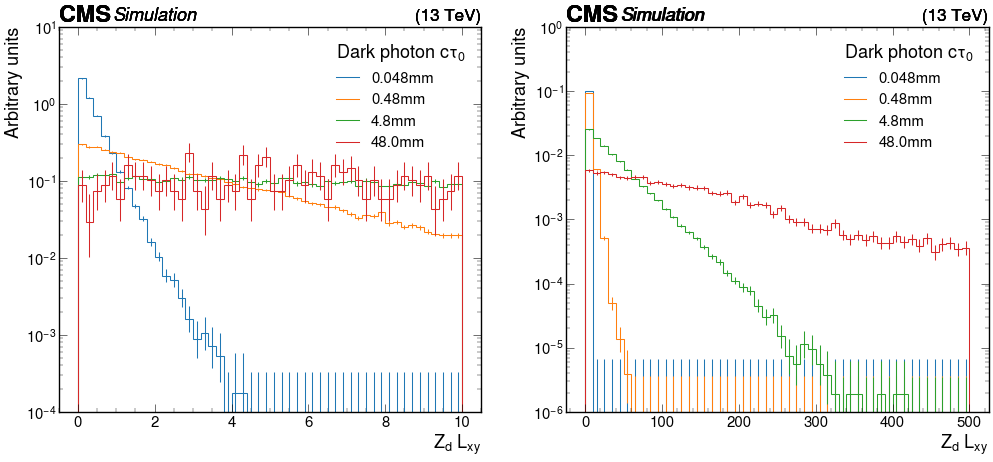

In [9]:
ctaus = [s.split("_")[-1].replace('p', '.') for s in extra_ctau_samples]
plt.subplots(1, 2, figsize=(2*12, 10))
plt.subplot(1, 2, 1)
for sample in extra_ctau_samples:
    utilities.plot(extra_ctau_out[sample]["hists"]["genAs_lxy_lowRange"][channels[0], ::2j], density=True, flow="none")
    plt.legend(ctaus, title=r"Dark photon $c\tau_0$", alignment="left")
    plt.ylim(1e-4, 10)
    plt.yscale("log")
    plt.ylabel("Arbitrary units")
plt.subplot(1, 2, 2)
for sample in extra_ctau_samples:
    utilities.plot(extra_ctau_out[sample]["hists"]["genAs_lxy"][channels[0], ::2j], density=True, flow="none")
    plt.legend(ctaus, title=r"Dark photon $c\tau_0$", alignment="left")
    plt.ylim(1e-6, 1)
    plt.yscale("log")
    plt.ylabel("Arbitrary units")
plt.savefig(f"{sidm_path}/plots/dark_photon_lxy.pdf", bbox_inches="tight")